In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [3]:
import torch
torch.cuda.is_available()

True

# Preprocessing

In [4]:
labels = pd.read_csv("../Datasets/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")
# labels.sample(10)

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [6]:
labels = labels.drop_duplicates("patientId")
# labels.info()

In [7]:
ROOT_PATH = Path("../Datasets/rsna-pneumonia-detection-challenge/stage_2_train_images/")
SAVE_PATH = Path("../Datasets/Processed/")

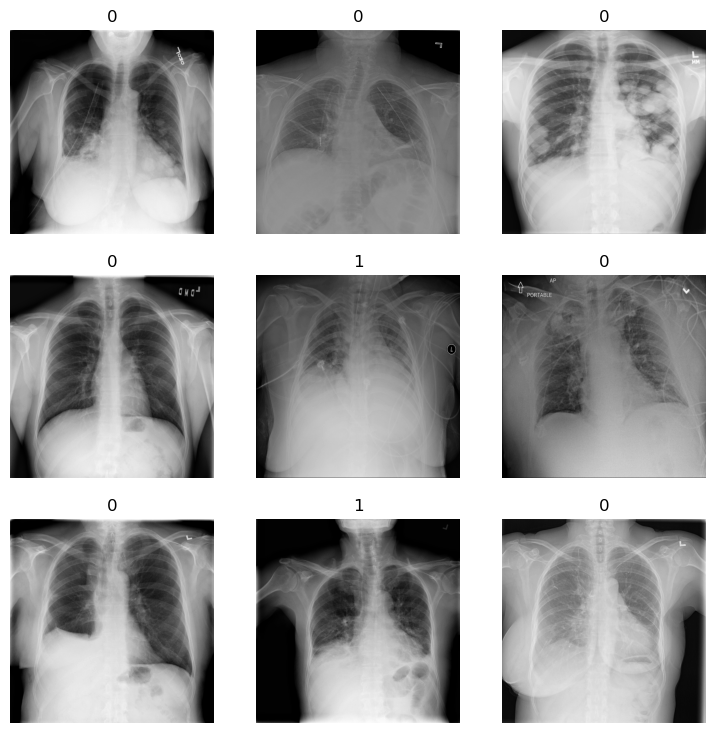

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
c = 0
for i in range(3):
    for j in range(3):
        pt_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/pt_id
        dcm_path = dcm_path.with_suffix('.dcm')
        dcm = pydicom.dcmread(dcm_path).pixel_array
        
        label = labels["Target"].iloc[c]
        
        axs[i][j].imshow(dcm, cmap='gray')
        axs[i][j].set_title(label)
        axs[i][j].axis('off')
        c += 1

In [19]:
sums = 0
sums_squared = 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix('.dcm')
    
    dcm = pydicom.read_file(dcm_path).pixel_array / 255
    
    dcm = cv2.resize(dcm, (224, 224)).astype(np.float16)
    
    label = labels.Target.iloc[c]
    
    train_or_val = "train" if c < 24000 else "val"
    
    current_save_path = SAVE_PATH/train_or_val/str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm)
    
    normalizer = dcm.shape[0] * dcm.shape[1]
    if train_or_val == 'train':
        sums += np.sum(dcm) / normalizer
        sums_squared += np.power(dcm, 2).sum() / normalizer

  0%|          | 0/26684 [00:00<?, ?it/s]

In [21]:
mean = sums / 24000
std = np.sqrt(sums_squared / 2400 - (mean**2))

NameError: name 'sums' is not defined

In [21]:
print(f"The mean is {mean} and std is {std}")

The mean is 0.4903962485384803 and std is 1.667090835251211


In [7]:
mean = 0.4903962485384803
std = 1.667090835251211

# Training

In [8]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [9]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomAffine(
        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)
    ),
    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [10]:
train_dataset = torchvision.datasets.DatasetFolder(
    "../Datasets/Processed/train",
    loader=load_file, extensions='npy', transform=train_transforms
)

val_dataset = torchvision.datasets.DatasetFolder(
    "../Datasets/Processed/val",
    loader=load_file, extensions='npy', transform=val_transforms
)

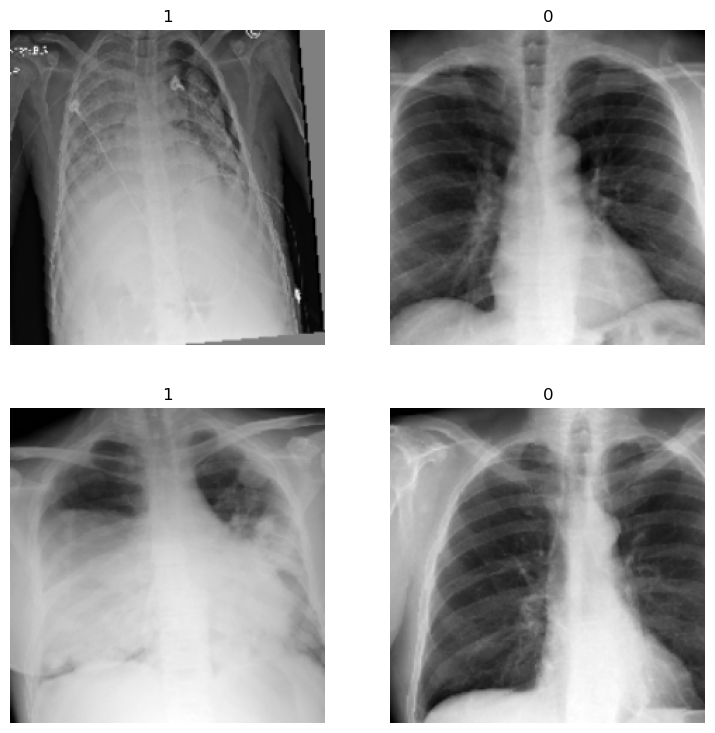

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_idx = np.random.randint(0, 24000)
        x_ray, label = train_dataset[random_idx]
        
        axs[i][j].imshow(x_ray[0], cmap='gray')
        axs[i][j].set_title(label)
        axs[i][j].axis('off')

In [93]:
batch_size = 16
num_workers = 12

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"Train: {len(train_loader)} and Val: {len(val_loader)}")

Train: 1500 and Val: 168


In [94]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

In [95]:
np.unique(val_dataset.targets, return_counts=True)

(array([0, 1]), array([2079,  605]))

In [96]:
class PneumeniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
        
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        
        
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self.model(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        
        self.log("Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        
        return loss
    
    def train_epoch_end(self, outs):
        self.log("Train Acc", self.train_acc.compute())
    
    def validation_step(self, batch, batch_idx):
            x_ray, label = batch
            label = label.float()
            pred = self.model(x_ray)[:, 0]
            loss = self.loss_fn(pred, label)

            self.log("Val Loss", loss)
            self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
#             self.validation_step_outputs.append(loss)
            return loss
    
    def validation_epoch_end(self, outs):
        self.log("Val Acc", self.val_acc.compute())
        
        
    def configure_optimizers(self):
        return [self.optimizer]

In [97]:
model = PneumeniaModel()

In [98]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="{epoch}-{val_loss:.2f}-{other_metric:.2f}",
    monitor="Val Acc",
    save_top_k=1,
    mode='max'
)

In [99]:
trainer = pl.Trainer(gpus=1, logger=TensorBoardLogger("./logs"), log_every_n_steps=1,
                    callbacks=checkpoint_callback, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [100]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | Accuracy          | 0     
3 | val_acc   | Accuracy          | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [102]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = PneumeniaModel.load_from_checkpoint("checkpoints/epoch=9-val_loss=0.00-other_metric=0.00.ckpt")
model.eval()
model.to(device);

In [107]:
preds = []
targets = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        targets.append(label)
preds = torch.tensor(preds)
targets = torch.tensor(targets).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [108]:
print(preds)
print(targets)

tensor([0.3388, 0.0228, 0.0109,  ..., 0.9026, 0.7534, 0.8322])
tensor([0, 0, 0,  ..., 1, 1, 1], dtype=torch.int32)


In [111]:
acc = torchmetrics.Accuracy()(preds, targets)
precision = torchmetrics.Precision()(preds, targets)
recall = torchmetrics.Recall()(preds, targets)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, targets)
cm_thresh = torchmetrics.ConfusionMatrix(num_classes=2, threshold=0.25)(preds, targets)

print("Accuracy", acc)
print("Precision", precision)
print("Recall", recall)
print("Confusion Matrix\n", cm)
print("Confusion Matric with Threshold\n", cm_thresh)

Accuracy tensor(0.8398)
Precision tensor(0.6369)
Recall tensor(0.6727)
Confusion Matrix
 tensor([[1847.,  232.],
        [ 198.,  407.]])
Confusion Matric with Threshold
 tensor([[1314.,  765.],
        [  44.,  561.]])


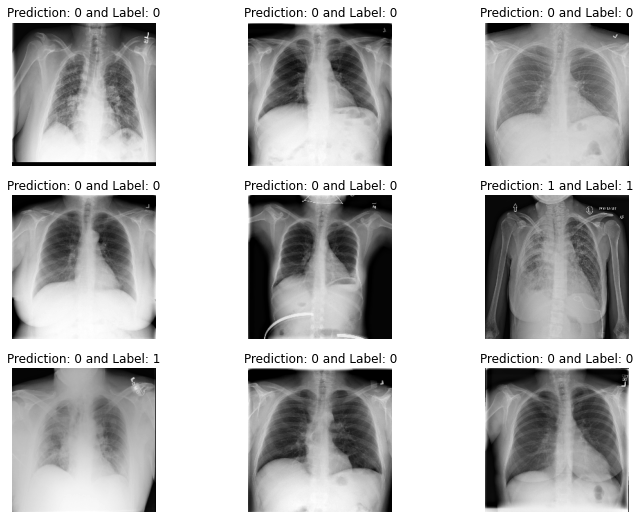

In [115]:
fig, axs = plt.subplots(3, 3, figsize=(12, 9))

for i in range(3):
    for j in range(3):
        random_idx = np.random.randint(0, len(preds))
        axs[i][j].imshow(val_dataset[random_idx][0][0], cmap='gray')
        axs[i][j].set_title(f"Prediction: {int(preds[random_idx] > 0.5)} and Label: {targets[random_idx]}")
        axs[i][j].axis('off')

# Interpretability

In [150]:
class CamPneumeniaClass(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])
        
    def forward(self, data):
        feature_map = self.feature_map(data)
        
        avg_pool_out = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        
        avg_pool_out_flattened = torch.flatten(avg_pool_out)
        
        pred = self.model.fc(avg_pool_out_flattened)
        
        return pred, feature_map

In [162]:
def cam(model, img):
    print(img.unsqueeze(0).shape)
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
        
    features = features.reshape((512, 49))
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params.detach()[0]
    print(features.shape)
    print(weight.shape)
    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7, 7).cpu()
    return cam_img, torch.sigmoid(pred)

In [152]:
model = CamPneumeniaClass.load_from_checkpoint('checkpoints/epoch=9-val_loss=0.00-other_metric=0.00.ckpt', strict=False)
model.eval();

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/pytorch_lightning/core/saving.py:206: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['feature_map.0.weight', 'feature_map.1.weight', 'feature_map.1.bias', 'feature_map.1.running_mean', 'feature_map.1.running_var', 'feature_map.4.0.conv1.weight', 'feature_map.4.0.bn1.weight', 'feature_map.4.0.bn1.bias', 'feature_map.4.0.bn1.running_mean', 'feature_map.4.0.bn1.running_var', 'feature_map.4.0.conv2.weight', 'feature_map.4.0.bn2.weight', 'feature_map.4.0.bn2.bias', 'feature_map.4.0.bn2.running_mean', 'feature_map.4.0.bn2.running_var', 'feature_map.4.1.conv1.weight', 'feature_map.4.1.bn1.weight', 'feature_map.4.1.bn1.bias', 'feature_map.4.1.bn1.running_mean', 'feature_map.4.1.bn1.running_var', 'feature_map.4.1.conv2.weight', 'feature_map.4.1.bn2.weight', 'feature_map.4.1.bn2.bias', 'feature_map.4.1.bn2.running_mean', 'feature_map.4.1.bn2.running_var', 'feature_map.5.0.conv1.weight', 'featu

In [158]:
def visualize(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]
    
    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(img, cmap="bone")
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    plt.title(pred)

In [161]:
img = val_dataset[6][0]
cam_img, pred = cam(model, img)

TypeError: 'Tensor' object is not callable

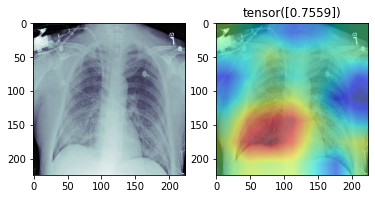

In [160]:
visualize(img, cam_img, pred)